In [1]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv("data/dataset-loslagos-8months.csv", 
                 sep=";", 
                 engine='python')
df.columns = ["date", "media_outlet", "url", "title", "text"]
df["content"] = ""
df.content = df.title + " " + df.text
print("Largo del dataset: ", len(df))
df.head()

Largo del dataset:  29598


,date,media_outlet,url,title,text,content
0,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/reconocen-a-g...,Reconocen a guardaparques de la Región de Los ...,Distintos protagonistas de los parques naciona...,Reconocen a guardaparques de la Región de Los ...
1,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/con-nuevos-ma...,Con nuevos materiales comienza plan piloto en ...,Centro de negocios Sercotec coordina acuerdos ...,Con nuevos materiales comienza plan piloto en ...
2,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/centro-de-sal...,Centro de Salud Familiar CESFAM Puerto Varas i...,Las horas se solicitan en el SOME o bien a tra...,Centro de Salud Familiar CESFAM Puerto Varas i...
3,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/alcalde-tomas...,Alcalde Tomás Gárate presidió por primera vez ...,Los y las consejeras destacaron el hecho de vo...,Alcalde Tomás Gárate presidió por primera vez ...
4,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/galeria-de-ar...,Galería de Arte Machacoya realizará remate de ...,"Hoy viernes a las 18:30 horas, en Machacoya At...",Galería de Arte Machacoya realizará remate de ...


<img src="img/los_lagos.png" />

Fuente: [wikipedia](https://es.wikipedia.org/wiki/Portal:Regi%C3%B3n_de_Los_Lagos/Comunas_de_Los_Lagos)

In [4]:
comunas = ["ancud", "castro", "chonchi", "curaco de vélez", "dalcahue", 
           "puqueldón", "queilén", "quemchi", "quellón", "quinchao"
           "calbuco", "cochamó", "fresia", "frutillar", "llanquihue"
           "los muermos", "maullin", "puerto montt", "puerto varas", "osorno"
           "puerto octay", "purranque", "puyehue", "rio negro", "san juan de la costa",
           "san pablo", "chaitén", "futaleufú", "hualaihué", "palena"]

In [5]:
from tqdm.notebook import tqdm_notebook

df['comuna'] = ""
for index, row in tqdm_notebook(df.iterrows(), desc="buscando comunas en content"):
    found = [comuna for comuna in comunas if(comuna in str(row["content"]).lower())]
    if(len(found)!= 0): df.at[index, 'comuna'] = found


buscando comunas en content: 0it [00:00, ?it/s]

In [7]:
selection = ['ancud']
mask = df.comuna.apply(lambda x: any(item for item in selection if item in x))

df1 = df[mask]
df1.head()

,date,media_outlet,url,title,text,content,comuna
7,2021-10-01,seminariolocal,https://www.semanariolocal.cl/archivos/2207,Gremio médico rechaza cierre de camas críticas...,El Capítulo Médico Ancud y el Consejo Regional...,Gremio médico rechaza cierre de camas críticas...,"[ancud, puerto montt]"
33,2021-10-01,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Acercan atención de salud a los vecinos de Tri...,El corte de cinta de la Estación Médico Rural ...,Acercan atención de salud a los vecinos de Tri...,"[ancud, quellón]"
34,2021-10-01,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Puqueldón avanza a apertura en el fin del Esta...,"El avance de Puqueldón a la apertura inicial, ...",Puqueldón avanza a apertura en el fin del Esta...,"[ancud, castro, puqueldón, quellón]"
36,2021-10-01,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Celebran Día de la Rabia con acciones preventivas,Una demostración de adiestramiento de mascotas...,Celebran Día de la Rabia con acciones preventi...,"[ancud, quemchi]"
39,2021-10-01,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,denuncia y ayuda,no espere de más por atenciones en cesfam.- El...,denuncia y ayuda no espere de más por atencion...,"[ancud, castro, chonchi, dalcahue, quellón]"


### [Topic Modelling in Embedding Spaces](https://github.com/lffloyd/embedded-topic-model)

In [22]:
#!python -m spacy download es_core_news_md
#!pip install -U embedded_topic_model
!python -m spacy validate


| Loading compatibility table...
[+] Loaded compatibility table

================= Installed pipeline packages (spaCy v3.3.0) =================
[i] spaCy installation:
C:\Users\56981\miniconda3\envs\etm\lib\site-packages\spacy

NAME              SPACY                 VERSION      
es_core_news_md   >=3.3.0.dev0,<3.4.0   3.3.0     [+]
es_core_news_sm   >=3.3.0.dev0,<3.4.0   3.3.0     [+]



In [23]:
import torch 
import spacy

nlp = spacy.load("es_core_news_sm")

print(torch.__version__)

1.6.0


In [24]:
def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens

In [25]:
import re
from sklearn.feature_extraction.text import CountVectorizer

myStopWords=['gnl','=','$','+','a','e','o','u','y',' ','  ','   ','    ']
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))

tf = tf_vectorizer.fit_transform(df1.content)
diccionario= tf_vectorizer.get_feature_names()

In [26]:
noticias = df1.content # para agilizar las cosas

In [27]:
#preparando los datos para su análisis y visualización
import numpy as np

td= {'tokens':[],'counts':[]}
doc_l = np.zeros(len(noticias))
term_f= np.zeros(len(diccionario))
for i in range(0,len(noticias)):
        tok=[]
        cou=[]
        for j in range(0,len(diccionario)):
             if(tf[i,j]>=1):
                term_f[j] = term_f[j] + tf[i,j]
                doc_l[i] = doc_l[i]+ tf[i,j]
                tok.append(j)
                cou.append(tf[i,j])
        td['tokens'].append(np.array(tok))
        td['counts'].append(np.array(cou))
td['tokens']= np.array(td['tokens'],dtype=object)
td['counts']= np.array(td['counts'],dtype=object)



Cargar un modelo Word2Vec pre-entrenado para el español         
Ver: https://github.com/dccuchile/spanish-word-embeddings

##### Word2Vec embeddings from SBWC
Links to the embeddings (#dimensions=300, #vectors=1,000,653): 
[Vector format (.txt.bz2)](http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2)

In [30]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [31]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance

true_k=3
etm_instance = ETM(
    diccionario,
    embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
    num_topics=true_k,
    epochs=300,
    debug_mode=True,
    train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
)

etm_instance.fit(td)

Topics before training: [['loma-osorio', 'm铆', 'varinio', 'uarac', '2021-2022', 'montecarmelo', 'ubaldo', 'rebolledo', 'fip', 'juvenal'], ['curumilla', 'quéilen', 'silvo-agropecuarios', 'wañilen', 'putemún', 'karyn', 'transporteinforma', '5to', 'hipertensión.respecto', 'veníar'], ['expres贸', 'gigantecer', 'inés', 'vertient', 'férreir', 'movic', 'agreg贸', 'gillies', 'saés', 'condizar']]
Epoch 1 - Learning Rate: 0.005 - KL theta: 0.06 - Rec loss: 1953.9 - NELBO: 1953.96
Epoch 2 - Learning Rate: 0.005 - KL theta: 0.51 - Rec loss: 1884.4 - NELBO: 1884.91
Epoch 3 - Learning Rate: 0.005 - KL theta: 0.21 - Rec loss: 1946.73 - NELBO: 1946.94
Epoch 4 - Learning Rate: 0.005 - KL theta: 0.61 - Rec loss: 1807.51 - NELBO: 1808.12
Epoch 5 - Learning Rate: 0.005 - KL theta: 0.4 - Rec loss: 1826.15 - NELBO: 1826.55
Epoch 6 - Learning Rate: 0.005 - KL theta: 0.33 - Rec loss: 1774.45 - NELBO: 1774.78
Epoch 7 - Learning Rate: 0.005 - KL theta: 1.15 - Rec loss: 1719.79 - NELBO: 1720.94
Epoch 8 - Learning 

Epoch 69 - Learning Rate: 0.005 - KL theta: 3.93 - Rec loss: 1614.45 - NELBO: 1618.38
Epoch 70 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1729.57 - NELBO: 1733.53
Topics: [['castro', '°', 'comuna', 'quellón', 'chonchi', 'covid-19', 'provincia', 'lago', 'queilen', 'lirar'], ['chiloé', 'osorno', 'dalcahue', 'covid', 'vélez', 'quemchi', 'curaco', 'chiloto', 'puyehue', 'contagio'], ['nacional', 'sitio', 'regional', 'comunidad', 'país', 'región', 'actividad', 'población', 'salud', 'estar']]
Epoch 71 - Learning Rate: 0.005 - KL theta: 3.8 - Rec loss: 1621.83 - NELBO: 1625.63
Epoch 72 - Learning Rate: 0.005 - KL theta: 3.95 - Rec loss: 1644.57 - NELBO: 1648.52
Epoch 73 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1679.93 - NELBO: 1683.89
Epoch 74 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1622.26 - NELBO: 1626.48
Epoch 75 - Learning Rate: 0.005 - KL theta: 4.15 - Rec loss: 1831.7 - NELBO: 1835.85
Epoch 76 - Learning Rate: 0.005 - KL theta: 4.36 - Rec loss: 1696.3 - NE

Epoch 138 - Learning Rate: 0.005 - KL theta: 4.25 - Rec loss: 1657.24 - NELBO: 1661.49
Epoch 139 - Learning Rate: 0.005 - KL theta: 4.04 - Rec loss: 1692.98 - NELBO: 1697.02
Epoch 140 - Learning Rate: 0.005 - KL theta: 4.07 - Rec loss: 1627.02 - NELBO: 1631.09
Topics: [['comuna', 'castro', '°', 'quellón', 'provincia', 'chonchi', 'lago', 'c', 'covid-19', 'quinchao'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'covid', 'quemchi', 'curaco', 'contagio', 'chacao', 'ancuditano'], ['regional', 'región', 'comunidad', 'país', 'nacional', 'sitio', 'actividad', 'población', 'proyecto', 'puerto']]
Epoch 141 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1758.71 - NELBO: 1762.93
Epoch 142 - Learning Rate: 0.005 - KL theta: 4.1 - Rec loss: 1672.45 - NELBO: 1676.55
Epoch 143 - Learning Rate: 0.005 - KL theta: 4.19 - Rec loss: 1646.2 - NELBO: 1650.39
Epoch 144 - Learning Rate: 0.005 - KL theta: 4.06 - Rec loss: 1594.79 - NELBO: 1598.85
Epoch 145 - Learning Rate: 0.005 - KL theta: 4.35 - Rec loss: 

Epoch 207 - Learning Rate: 0.005 - KL theta: 4.51 - Rec loss: 1697.73 - NELBO: 1702.24
Epoch 208 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1621.86 - NELBO: 1626.08
Epoch 209 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1616.97 - NELBO: 1620.93
Epoch 210 - Learning Rate: 0.005 - KL theta: 4.31 - Rec loss: 1655.27 - NELBO: 1659.58
Topics: [['castro', 'comuna', '°', 'provincia', 'quellón', 'c', 'lago', 'chonchi', 'san', 'carlos'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'quemchi', 'covid', 'curaco', 'contagio', 'ancuditano', 'influenza'], ['región', 'regional', 'comunidad', 'país', 'sitio', 'nacional', 'actividad', 'puerto', 'agua', 'proyecto']]
Epoch 211 - Learning Rate: 0.005 - KL theta: 4.3 - Rec loss: 1695.86 - NELBO: 1700.16
Epoch 212 - Learning Rate: 0.005 - KL theta: 4.04 - Rec loss: 1612.32 - NELBO: 1616.36
Epoch 213 - Learning Rate: 0.005 - KL theta: 4.33 - Rec loss: 1579.5 - NELBO: 1583.83
Epoch 214 - Learning Rate: 0.005 - KL theta: 4.3 - Rec loss: 1616.67 - 

Epoch 276 - Learning Rate: 0.005 - KL theta: 4.15 - Rec loss: 1639.1 - NELBO: 1643.25
Epoch 277 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1647.23 - NELBO: 1651.76
Epoch 278 - Learning Rate: 0.005 - KL theta: 4.45 - Rec loss: 1743.7 - NELBO: 1748.15
Epoch 279 - Learning Rate: 0.005 - KL theta: 4.37 - Rec loss: 1696.93 - NELBO: 1701.3
Epoch 280 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1688.46 - NELBO: 1692.99
Topics: [['castro', 'comuna', '°', 'provincia', 'quellón', 'c', 'lago', 'chonchi', 'covid-19', 'san'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'chiloto', 'curaco', 'quemchi', 'covid', 'contagio', 'ancuditano'], ['región', 'regional', 'comunidad', 'país', 'nacional', 'sitio', 'actividad', 'proyecto', 'puerto', 'persona']]
Epoch 281 - Learning Rate: 0.005 - KL theta: 4.38 - Rec loss: 1609.48 - NELBO: 1613.86
Epoch 282 - Learning Rate: 0.005 - KL theta: 4.2 - Rec loss: 1603.75 - NELBO: 1607.95
Epoch 283 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1681.92 

In [32]:
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=3
nDoc = len(noticias)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)

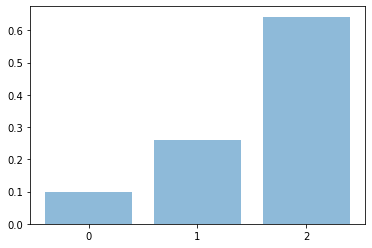

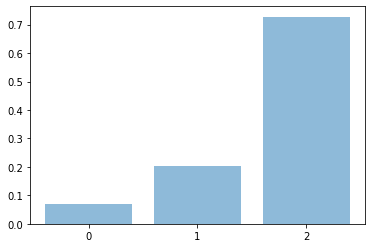

[0.07906573, 0.06367467, 0.05751381, 0.054420486, 0.044131655, 0.03974564, 0.039127503, 0.028424766, 0.026870199, 0.02151831, 0.02133213, 0.01810096, 0.011895524, 0.011847973, 0.010129364]


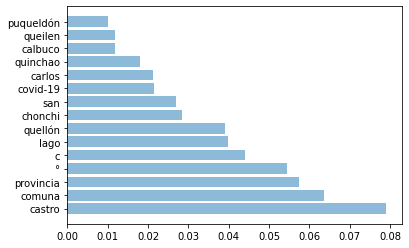

[0.019506535, 0.0075779986, 0.0041287593, 0.002662233, 0.0024236126, 0.0021268665, 0.002076415, 0.0016563722, 0.0014845104, 0.0014029797, 0.0013936646, 0.0013819324, 0.0012921306, 0.0011042552, 0.0010492492]


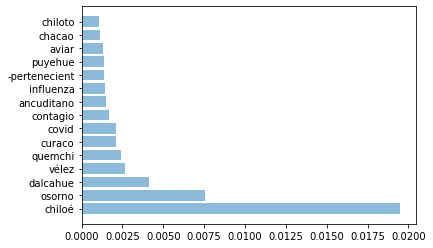

[0.006036616, 0.005897976, 0.0052111987, 0.005172558, 0.0045215352, 0.004133881, 0.003949953, 0.0036640577, 0.0034090134, 0.0032291035, 0.0031510664, 0.0030860256, 0.0030218204, 0.0029495067, 0.002896726]


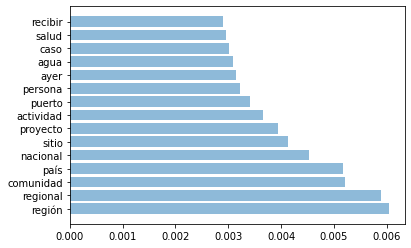

In [35]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()

In [40]:
import pyLDAvis

prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

C:\Users\56981\miniconda3\envs\etm\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\56981\miniconda3\envs\etm\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [41]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance

true_k=3
etm_instance = ETM(
    diccionario,
    embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
    num_topics=true_k,
    epochs=300,
    debug_mode=True,
    train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
)

etm_instance.fit(td)

Topics before training: [['loma-osorio', 'm铆', 'varinio', 'uarac', '2021-2022', 'montecarmelo', 'ubaldo', 'rebolledo', 'fip', 'juvenal'], ['curumilla', 'quéilen', 'silvo-agropecuarios', 'wañilen', 'putemún', 'karyn', 'transporteinforma', '5to', 'hipertensión.respecto', 'veníar'], ['expres贸', 'gigantecer', 'inés', 'vertient', 'férreir', 'movic', 'agreg贸', 'gillies', 'saés', 'condizar']]
Epoch 1 - Learning Rate: 0.005 - KL theta: 0.06 - Rec loss: 1953.9 - NELBO: 1953.96
Epoch 2 - Learning Rate: 0.005 - KL theta: 0.51 - Rec loss: 1884.4 - NELBO: 1884.91
Epoch 3 - Learning Rate: 0.005 - KL theta: 0.21 - Rec loss: 1946.73 - NELBO: 1946.94
Epoch 4 - Learning Rate: 0.005 - KL theta: 0.61 - Rec loss: 1807.51 - NELBO: 1808.12
Epoch 5 - Learning Rate: 0.005 - KL theta: 0.4 - Rec loss: 1826.15 - NELBO: 1826.55
Epoch 6 - Learning Rate: 0.005 - KL theta: 0.33 - Rec loss: 1774.45 - NELBO: 1774.78
Epoch 7 - Learning Rate: 0.005 - KL theta: 1.15 - Rec loss: 1719.79 - NELBO: 1720.94
Epoch 8 - Learning 

Epoch 69 - Learning Rate: 0.005 - KL theta: 3.93 - Rec loss: 1614.45 - NELBO: 1618.38
Epoch 70 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1729.57 - NELBO: 1733.53
Topics: [['castro', '°', 'comuna', 'quellón', 'chonchi', 'covid-19', 'provincia', 'lago', 'queilen', 'lirar'], ['chiloé', 'osorno', 'dalcahue', 'covid', 'vélez', 'quemchi', 'curaco', 'chiloto', 'puyehue', 'contagio'], ['nacional', 'sitio', 'regional', 'comunidad', 'país', 'región', 'actividad', 'población', 'salud', 'estar']]
Epoch 71 - Learning Rate: 0.005 - KL theta: 3.8 - Rec loss: 1621.83 - NELBO: 1625.63
Epoch 72 - Learning Rate: 0.005 - KL theta: 3.95 - Rec loss: 1644.57 - NELBO: 1648.52
Epoch 73 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1679.93 - NELBO: 1683.89
Epoch 74 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1622.26 - NELBO: 1626.48
Epoch 75 - Learning Rate: 0.005 - KL theta: 4.15 - Rec loss: 1831.7 - NELBO: 1835.85
Epoch 76 - Learning Rate: 0.005 - KL theta: 4.36 - Rec loss: 1696.3 - NE

Epoch 138 - Learning Rate: 0.005 - KL theta: 4.25 - Rec loss: 1657.24 - NELBO: 1661.49
Epoch 139 - Learning Rate: 0.005 - KL theta: 4.04 - Rec loss: 1692.98 - NELBO: 1697.02
Epoch 140 - Learning Rate: 0.005 - KL theta: 4.07 - Rec loss: 1627.02 - NELBO: 1631.09
Topics: [['comuna', 'castro', '°', 'quellón', 'provincia', 'chonchi', 'lago', 'c', 'covid-19', 'quinchao'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'covid', 'quemchi', 'curaco', 'contagio', 'chacao', 'ancuditano'], ['regional', 'región', 'comunidad', 'país', 'nacional', 'sitio', 'actividad', 'población', 'proyecto', 'puerto']]
Epoch 141 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1758.71 - NELBO: 1762.93
Epoch 142 - Learning Rate: 0.005 - KL theta: 4.1 - Rec loss: 1672.45 - NELBO: 1676.55
Epoch 143 - Learning Rate: 0.005 - KL theta: 4.19 - Rec loss: 1646.2 - NELBO: 1650.39
Epoch 144 - Learning Rate: 0.005 - KL theta: 4.06 - Rec loss: 1594.79 - NELBO: 1598.85
Epoch 145 - Learning Rate: 0.005 - KL theta: 4.35 - Rec loss: 

Epoch 207 - Learning Rate: 0.005 - KL theta: 4.51 - Rec loss: 1697.73 - NELBO: 1702.24
Epoch 208 - Learning Rate: 0.005 - KL theta: 4.22 - Rec loss: 1621.86 - NELBO: 1626.08
Epoch 209 - Learning Rate: 0.005 - KL theta: 3.96 - Rec loss: 1616.97 - NELBO: 1620.93
Epoch 210 - Learning Rate: 0.005 - KL theta: 4.31 - Rec loss: 1655.27 - NELBO: 1659.58
Topics: [['castro', 'comuna', '°', 'provincia', 'quellón', 'c', 'lago', 'chonchi', 'san', 'carlos'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'quemchi', 'covid', 'curaco', 'contagio', 'ancuditano', 'influenza'], ['región', 'regional', 'comunidad', 'país', 'sitio', 'nacional', 'actividad', 'puerto', 'agua', 'proyecto']]
Epoch 211 - Learning Rate: 0.005 - KL theta: 4.3 - Rec loss: 1695.86 - NELBO: 1700.16
Epoch 212 - Learning Rate: 0.005 - KL theta: 4.04 - Rec loss: 1612.32 - NELBO: 1616.36
Epoch 213 - Learning Rate: 0.005 - KL theta: 4.33 - Rec loss: 1579.5 - NELBO: 1583.83
Epoch 214 - Learning Rate: 0.005 - KL theta: 4.3 - Rec loss: 1616.67 - 

Epoch 276 - Learning Rate: 0.005 - KL theta: 4.15 - Rec loss: 1639.1 - NELBO: 1643.25
Epoch 277 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1647.23 - NELBO: 1651.76
Epoch 278 - Learning Rate: 0.005 - KL theta: 4.45 - Rec loss: 1743.7 - NELBO: 1748.15
Epoch 279 - Learning Rate: 0.005 - KL theta: 4.37 - Rec loss: 1696.93 - NELBO: 1701.3
Epoch 280 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1688.46 - NELBO: 1692.99
Topics: [['castro', 'comuna', '°', 'provincia', 'quellón', 'c', 'lago', 'chonchi', 'covid-19', 'san'], ['chiloé', 'osorno', 'dalcahue', 'vélez', 'chiloto', 'curaco', 'quemchi', 'covid', 'contagio', 'ancuditano'], ['región', 'regional', 'comunidad', 'país', 'nacional', 'sitio', 'actividad', 'proyecto', 'puerto', 'persona']]
Epoch 281 - Learning Rate: 0.005 - KL theta: 4.38 - Rec loss: 1609.48 - NELBO: 1613.86
Epoch 282 - Learning Rate: 0.005 - KL theta: 4.2 - Rec loss: 1603.75 - NELBO: 1607.95
Epoch 283 - Learning Rate: 0.005 - KL theta: 4.53 - Rec loss: 1681.92 

In [43]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)

0.13174671753179543
1.0
